<a href="https://colab.research.google.com/github/rodrigoDambrosio/colab-notebooks-ia-models/blob/main/3664_IA_C1_equipo_5_trabajo_practico_ML_Regresion_Entrenamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Modelo para esperanza de vida**
Para este modelo usaremos un dataset con datos de la organización mundial de la salud.

Nuestro objetivo es estimar la esperanza de vida a partir de diversos factores relevantes para su cálculo, tanto de índole sanitaria como económica.

[Life expectancy (WHO) fixed](https://www.kaggle.com/datasets/lashagoch/life-expectancy-who-updated)

## Importamos las librerias necesarias

In [ ]:
# Importación de librerías.
import numpy as np  # Operaciones matemáticas.
import pandas as pd # Manipulación de datasets.
import seaborn as sns # Generación de gráficos.
import matplotlib.pyplot as matplot # Generación de gráficos.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Cargamos el Dataset

### Opción 1: Importar una versión concreta del archivo desde un drive

In [ ]:
# Importación de una versión concreta del archivo desde drive
from google.colab import drive
drive.mount('/content/drive')
ruta_archivo = "/content/drive/MyDrive/colab_files/Life-Expectancy-Data-Updated.csv"
dataset = pd.read_csv(ruta_archivo)


KeyboardInterrupt: 

### Opción 2: Importar la última versión del archivo desde kagglehub

In [ ]:
import kagglehub
path = kagglehub.dataset_download("lashagoch/life-expectancy-who-updated")
dataset = pd.read_csv(path+'/Life-Expectancy-Data-Updated.csv')

## Verificación de carga

In [ ]:
#Verificamos que haya cargado correctamente visualizando los primeros archivos
dataset.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


## Preprocesamiento y preparacion de datos

El dataset incluye dos columnas binarias: economy_status_Developed y economy_status_Developing, que representan el estado económico del país. Para evitar redundancias, se evaluó si ambas eran complementarias, es decir, si cuando una tiene valor 1 la otra tiene 0, y viceversa.

In [ ]:
complementarias = (dataset['Economy_status_Developed'] + dataset['Economy_status_Developing'] == 1).all()
print("Complementariedad entre columnas:", "Sí" if complementarias else "No")

Complementariedad entre columnas: Sí


Dado que ambas columnas son complementarias, se eliminó `Economy_status_Developing`, ya que `Economy_status_Developed` por sí sola es suficiente para representar la información.

In [ ]:
dataset = dataset.drop('Economy_status_Developing', axis=1)

Decidimos eliminar la columna `Country` porque no aporta información útil para predecir la esperanza de vida. Al ser simplemente el nombre del país, no contribuye directamente al modelo y podría generar ruido. Preferimos enfocarnos en variables que sean más informativas y generalizables.

In [ ]:
dataset = dataset.drop('Country', axis=1)

Análisis de datos faltantes

In [ ]:
total_registros = dataset.shape[0]
registros_nan = dataset.isna().any(axis=1).sum()

print(f'Cantidad de registros con NaN: {registros_nan}')
print(f'Porcentaje de registros con NaN: {(registros_nan / total_registros) * 100:.0f}%')


Cantidad de registros con NaN: 0
Porcentaje de registros con NaN: 0%


Dado que no hay registros NaN en el dataset no necesitamos realizar ningún tipo de limpieza

Se realizó un análisis exploratorio de la distribución de la esperanza de vida por región usando un boxplot:

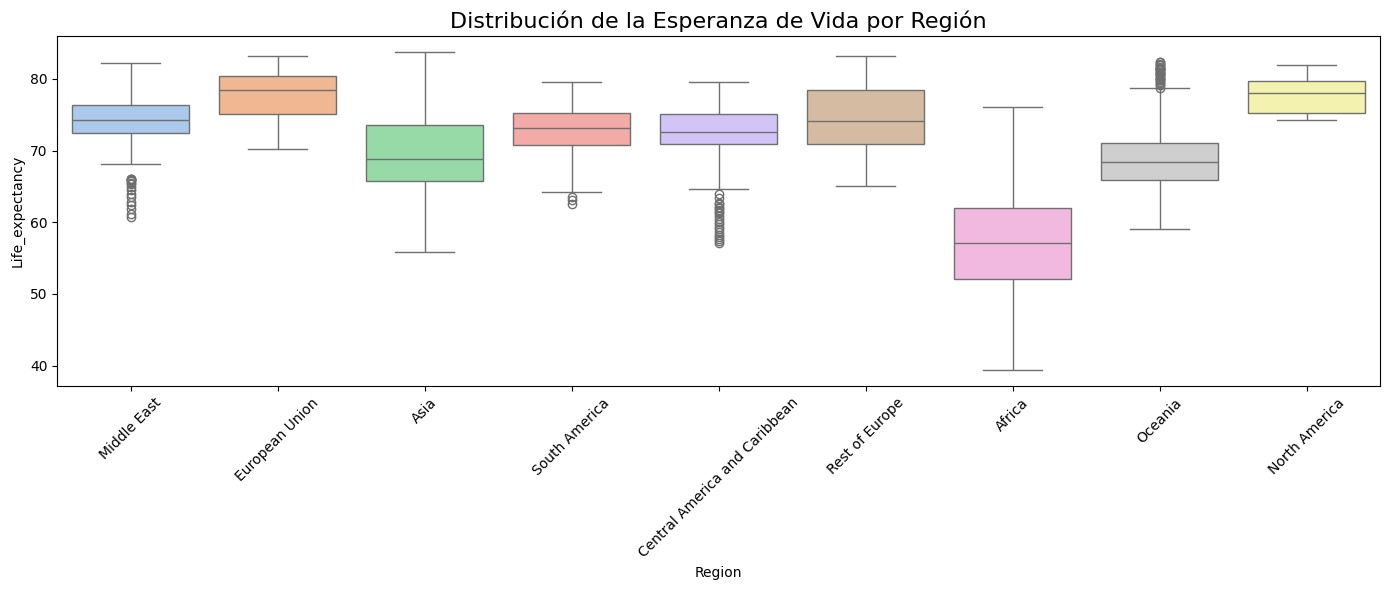

In [ ]:
matplot.figure(figsize=(14, 6))

sns.boxplot(
    data=dataset,
    x='Region',
    hue = 'Region',
    y='Life_expectancy',
    palette='pastel',
    legend = False
)

matplot.title('Distribución de la Esperanza de Vida por Región', fontsize=16)
matplot.xticks(rotation=45)
matplot.tight_layout()
matplot.show()


Además, se revisaron la cantidad de registros por región:

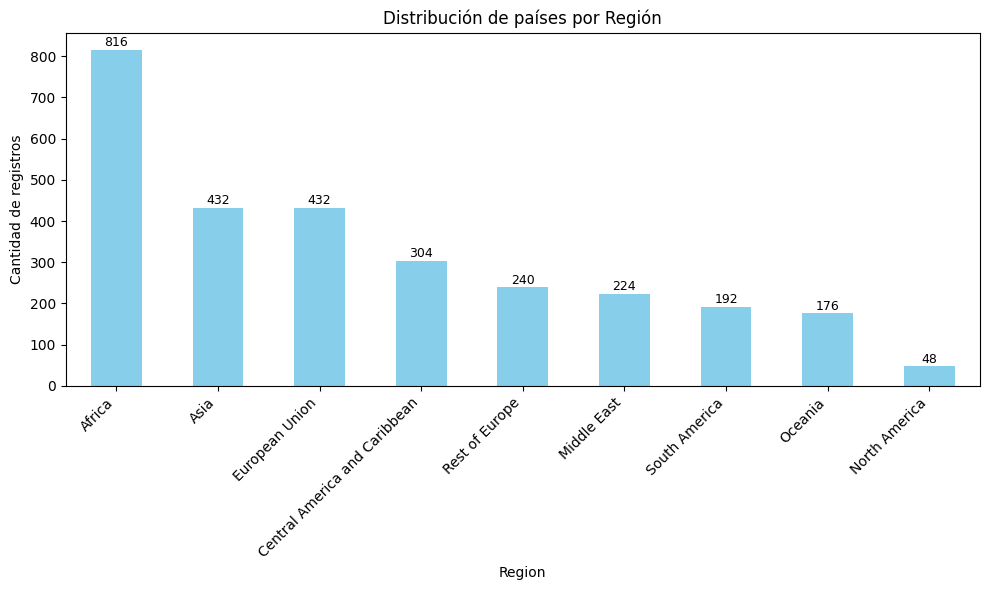

In [ ]:
region_counts = dataset['Region'].value_counts()

# Crear el gráfico
matplot.figure(figsize=(10, 6))
bars = region_counts.plot(kind='bar', color='skyblue')

matplot.title('Distribución de países por Región')
matplot.ylabel('Cantidad de registros')
matplot.xticks(rotation=45, ha='right')
matplot.tight_layout()

# Agregar los números sobre cada barra
for i, count in enumerate(region_counts):
    matplot.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=9)

Decidimos eliminar la columna `Region` porque no está directamente relacionado con la esperanza de vida, sino que representa condiciones socioeconómicas que ya están representadas por otras variables.
Además, su distribución es muy desigual (por ejemplo, África tiene 816 registros y América del Norte solo 48), lo que puede introducir sesgos o sobreajuste en el modelo.

In [ ]:
dataset = dataset.drop('Region', axis=1)

Se calculó y visualizó la matriz de correlación entre las variables numéricas restantes en el dataset para entender mejor las relaciones entre ellas:

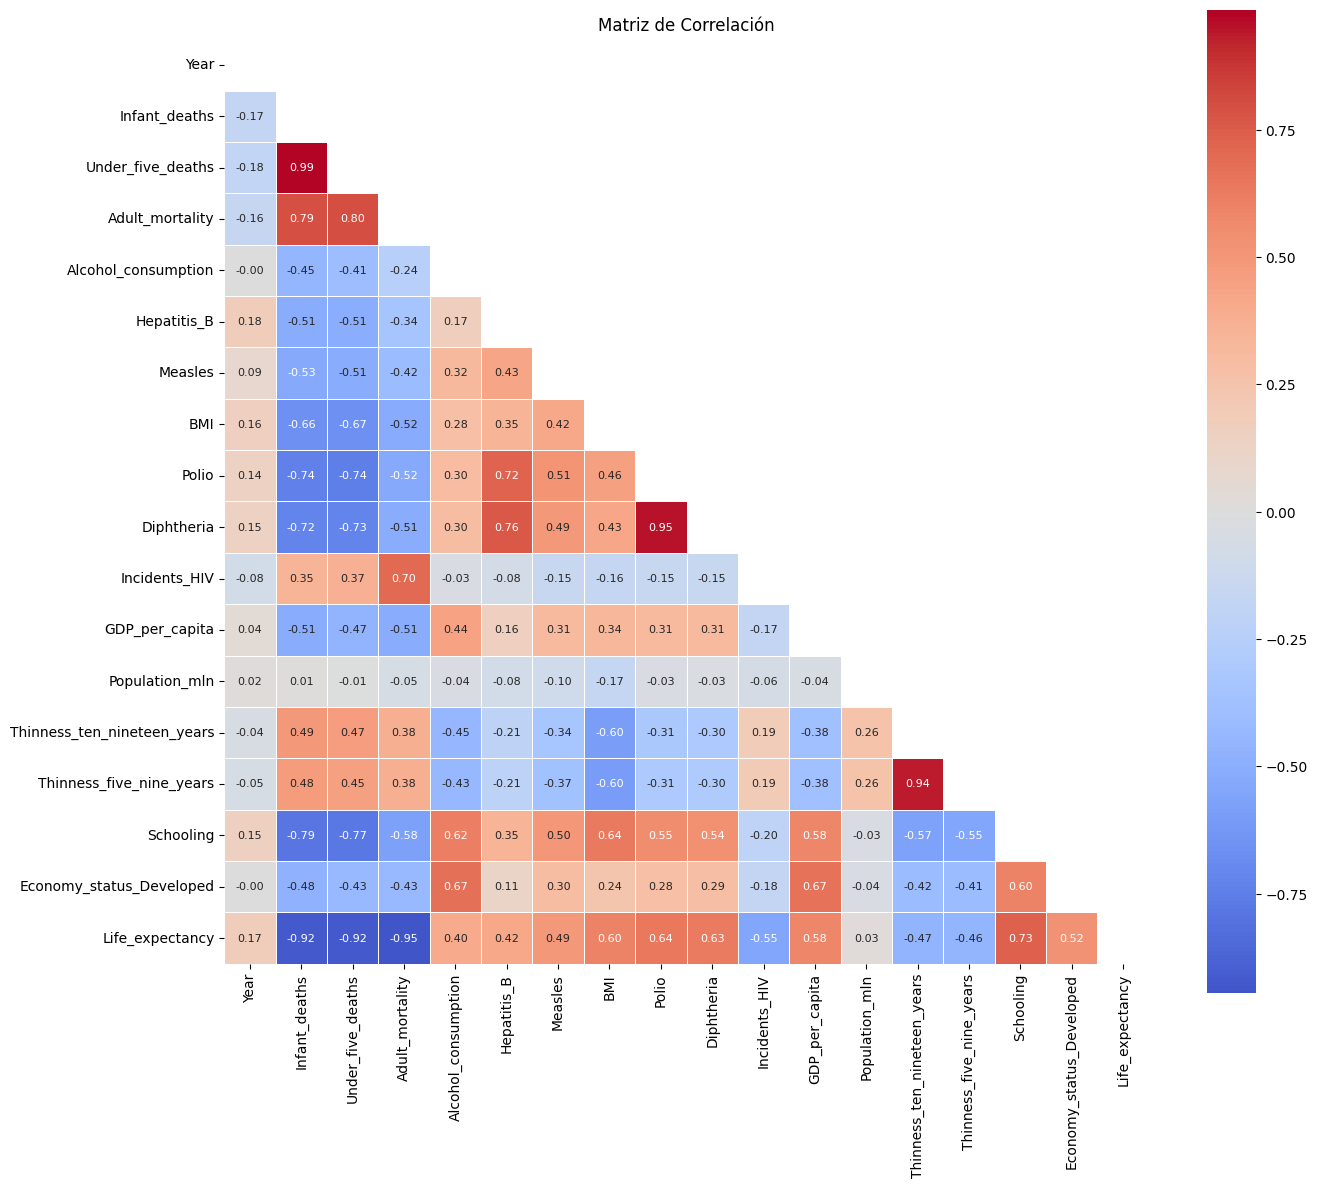

In [ ]:
correlation_matrix = dataset.corr()

matplot.figure(figsize=(14, 12))
# La máscara oculta la mitad superior de la matriz para evitar mostrar información duplicada,
# ya que la matriz de correlación es simétrica.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, square=True, linewidths=0.5, fmt='.2f', annot_kws={'size': 8})
matplot.title('Matriz de Correlación')
matplot.tight_layout()
matplot.show()



Las variables que muestran una correlación negativa fuerte con la esperanza de vida indican que a medida que aumentan estos factores, la esperanza de vida tiende a disminuir.

*   `Infant_deaths` y `Under_five_deaths` tienen una correlación muy fuerte negativa (-0.92). Esto significa que en los países o regiones donde la tasa de mortalidad infantil o de niños menores de cinco años es alta, la esperanza de vida promedio es considerablemente más baja. Esto es esperado, ya que la muerte temprana afecta directamente las estadísticas de vida promedio.

*   `Adult_mortality` presenta la correlación negativa más fuerte (-0.95), lo que indica que la mortalidad adulta tiene un gran impacto en reducir la esperanza de vida.

*   `Thinness_ten_nineteen_years` y `Thinness_five_nine_years` muestran una correlación negativa moderada (-0.47 y -0.46 respectivamente). Esto sugiere que la desnutrición o estado de delgadez en niños y adolescentes está asociada con una menor esperanza de vida, reflejando problemas de salud pública y nutrición.

*   `Incidents_HIV` también tiene una correlación negativa moderada (-0.55), evidenciando que una mayor incidencia de VIH reduce la expectativa de vida, probablemente por las complicaciones relacionadas a esta enfermedad.
   
    
---


Las variables que muestran una correlación positiva con la esperanza de vida representan factores que, al aumentar, tienden a mejorar la expectativa de vida.

*   `Polio`, `Diphtheria`, y `Hepatitis_B` (con correlaciones entre 0.42 y 0.64) reflejan niveles de vacunación o cobertura sanitaria. Una mayor vacunación está asociada con una mayor esperanza de vida, ya que reduce enfermedades prevenibles.

*   `BMI` con correlación de 0.60 indica que un mejor estado nutricional (índice de masa corporal saludable) está vinculado a una mayor esperanza de vida.

*   `GDP_per_capita` (0.58) y `Schooling` (0.73) son indicadores socioeconómicos importantes. El ingreso per cápita refleja el desarrollo económico, mientras que el nivel educativo suele asociarse con mejores condiciones de vida, acceso a salud y mayor conciencia sobre estilos de vida saludables, lo que aumenta la expectativa de vida.

*   `Alcohol_consumption` presenta una correlación positiva moderada (0.40) con la esperanza de vida, lo cual puede parecer contraintuitivo. Esta relación posiblemente refleje que en países desarrollados, donde el consumo de alcohol es mayor, también se registra una mayor esperanza de vida debido a mejores servicios de salud y otros factores asociados. Sin embargo, dado que esta variable no refleja un efecto causal directo y podría estar mediada por múltiples factores externos, decidimos excluirla del modelo en la etapa de preprocesamiento para evitar introducir ruido o sesgos, simplificando así el análisis y mejorando la interpretabilidad del modelo.

---


`Population_mln` y `Year` muestran correlaciones muy bajas con la esperanza de vida (0.03 y 0.17 respectivamente), lo que indica que su relación lineal con esta variable es prácticamente nula o muy débil. Por lo tanto, no aportan información significativa para explicar la variabilidad de la esperanza de vida y elegimos excluirlas para simplificar el análisis.



In [ ]:
dataset = dataset.drop(['Year', 'Population_mln', 'Alcohol_consumption'], axis=1)

### Tratamiento Outliers

Observamos características estadísticas generales del dataset

In [ ]:
dataset.describe()

,Infant_deaths,Under_five_deaths,Adult_mortality,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Life_expectancy
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,30.363792,42.938268,192.251775,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,4.865852,4.899825,7.632123,0.206704,68.856075
std,27.538117,44.569974,114.910281,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,4.438234,4.525217,3.171556,0.405012,9.405608
min,1.800000,2.300000,49.384000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.100000,0.100000,1.100000,0.000000,39.400000
25%,8.100000,9.675000,106.910250,78.000000,64.000000,23.200000,81.000000,81.000000,0.080000,1415.750000,1.600000,1.600000,5.100000,0.000000,62.700000
50%,19.600000,23.100000,163.841500,89.000000,83.000000,25.500000,93.000000,93.000000,0.150000,4217.000000,3.300000,3.400000,7.800000,0.000000,71.400000
75%,47.350000,66.000000,246.791375,96.000000,93.000000,26.400000,97.000000,97.000000,0.460000,12557.000000,7.200000,7.300000,10.300000,0.000000,75.400000
max,138.100000,224.900000,719.360500,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,27.700000,28.600000,14.100000,1.000000,83.800000


No se observan valores atípicos evidentes que resulten inconsistentes con el dominio del problema.

Definimos una función para detectar outliers y marcarlos como tal en una columna aparte, ya que no queremos perder los datos de estos.

In [ ]:
def marcar_outliers(dataset, columnas, factor_iqr=5):
    resultado = dataset.copy()

    columnas = [col for col in columnas if col in resultado.columns]

    for col in columnas:
        print(f"\n Análisis de la columna: {col}")
        print("-" * 50)

        # Gráficos
        fig, axes = matplot.subplots(1, 2, figsize=(16, 4))
        sns.histplot(resultado[col], kde=True, ax=axes[0], color='lightblue')
        axes[0].set_title(f'Histograma de {col}')
        axes[0].set_xlabel(col)
        axes[0].grid(True)

        sns.boxplot(x=resultado[col], ax=axes[1], color='skyblue')
        axes[1].set_title(f'Boxplot de {col}')
        axes[1].set_xlabel(col)
        axes[1].grid(True)

        matplot.tight_layout()
        matplot.show()

        # Estadísticas básicas
        moda = resultado[col].mode().iloc[0]
        media = resultado[col].mean()
        mediana = resultado[col].median()
        asimetria = resultado[col].skew()
        print(f"Moda: {moda:.2f} | Mediana: {mediana:.2f} | Media: {media:.2f}")
        print(f"Asimetría: {asimetria:.2f}", end=' ')
        if asimetria > 1:
            print("→ Asimetría positiva fuerte (cola derecha)")
        elif asimetria > 0.5:
            print("→ Asimetría positiva moderada")
        elif asimetria < -1:
            print("→ Asimetría negativa fuerte (cola izquierda)")
        elif asimetria < -0.5:
            print("→ Asimetría negativa moderada")
        else:
            print("→ Distribución aproximadamente simétrica")

        # Cálculo IQR y límites
        Q1 = resultado[col].quantile(0.25)
        Q3 = resultado[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - factor_iqr * IQR
        limite_superior = Q3 + factor_iqr * IQR

        # Detectar outliers
        mascara_outliers = (resultado[col] < limite_inferior) | (resultado[col] > limite_superior)
        cantidad_outliers = mascara_outliers.sum()

        if cantidad_outliers > 0:
            outliers = resultado.loc[mascara_outliers, col]
            media_outliers = outliers.mean()
            mediana_outliers = outliers.median()
            porcentaje_outliers = (cantidad_outliers / len(resultado)) * 100

            print(f"\nCantidad de outliers: {cantidad_outliers}")
            print(f"Media de outliers: {media_outliers:.2f}")
            print(f"Mediana de outliers: {mediana_outliers:.2f}")
            print(f"Porcentaje de registros considerados outliers: {porcentaje_outliers:.2f}%")
        else:
            print("\nNo se encontraron outliers con el criterio definido.")

        # Crear columna booleana de outliers
        resultado[f'Outlier_{col}'] = mascara_outliers.astype(int)

    return resultado


In [ ]:
columnas_numericas = dataset.select_dtypes(include='number').columns.tolist()
print(columnas_numericas)

['Infant_deaths', 'Under_five_deaths', 'Adult_mortality', 'Hepatitis_B', 'Measles', 'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed', 'Life_expectancy']


Removimos la columna Economy_status_Developed del análisis de outliers porque es una variable binaria que solo toma valores 0 o 1, sin valores intermedios ni un rango continuo, por lo que no es apropiado aplicar métodos de detección de valores atípicos.


 Análisis de la columna: Infant_deaths
--------------------------------------------------


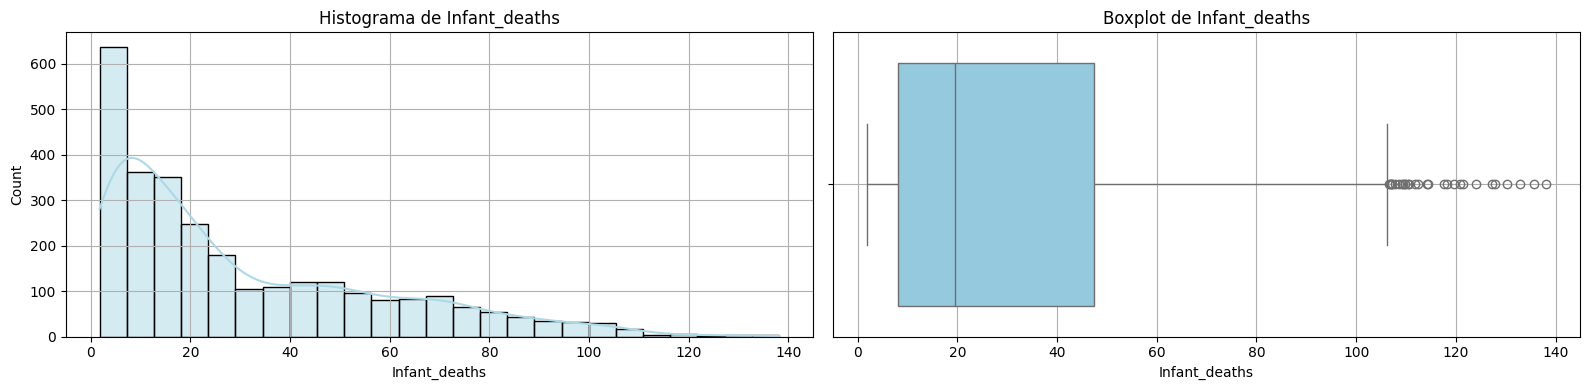

Moda: 3.30 | Mediana: 19.60 | Media: 30.36
Asimetría: 1.10 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 29
Media de outliers: 116.45
Mediana de outliers: 112.40
Porcentaje de registros considerados outliers: 1.01%

 Análisis de la columna: Under_five_deaths
--------------------------------------------------


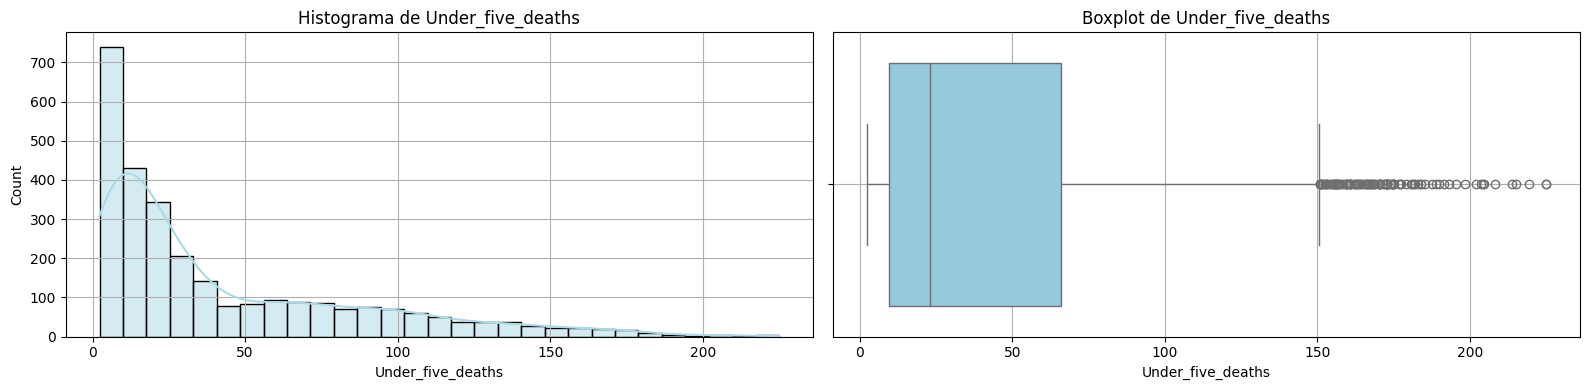

Moda: 4.10 | Mediana: 23.10 | Media: 42.94
Asimetría: 1.38 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 102
Media de outliers: 171.97
Mediana de outliers: 168.35
Porcentaje de registros considerados outliers: 3.56%

 Análisis de la columna: Adult_mortality
--------------------------------------------------


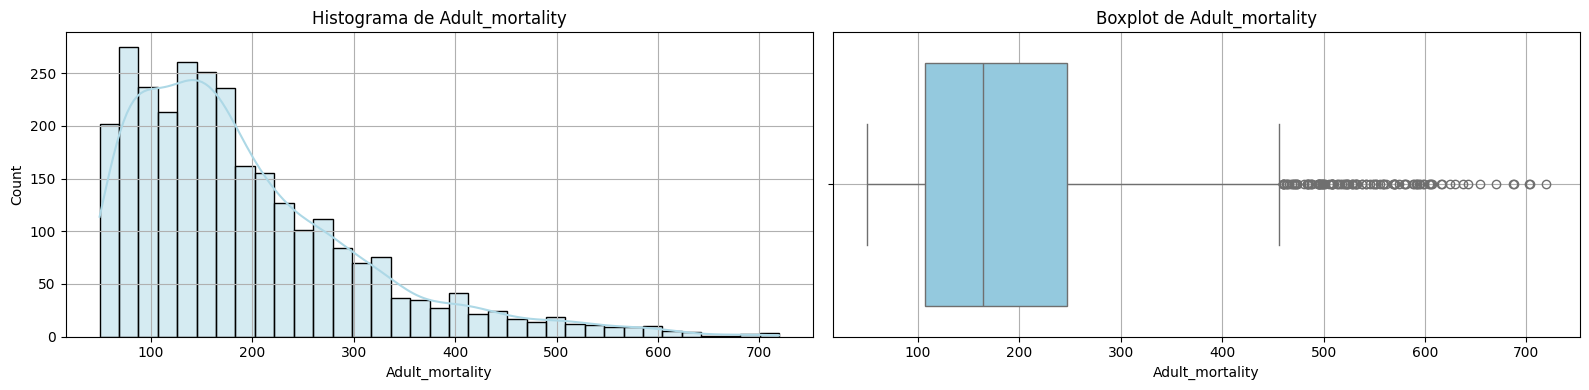

Moda: 91.95 | Mediana: 163.84 | Media: 192.25
Asimetría: 1.38 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 112
Media de outliers: 539.56
Mediana de outliers: 525.80
Porcentaje de registros considerados outliers: 3.91%

 Análisis de la columna: Hepatitis_B
--------------------------------------------------


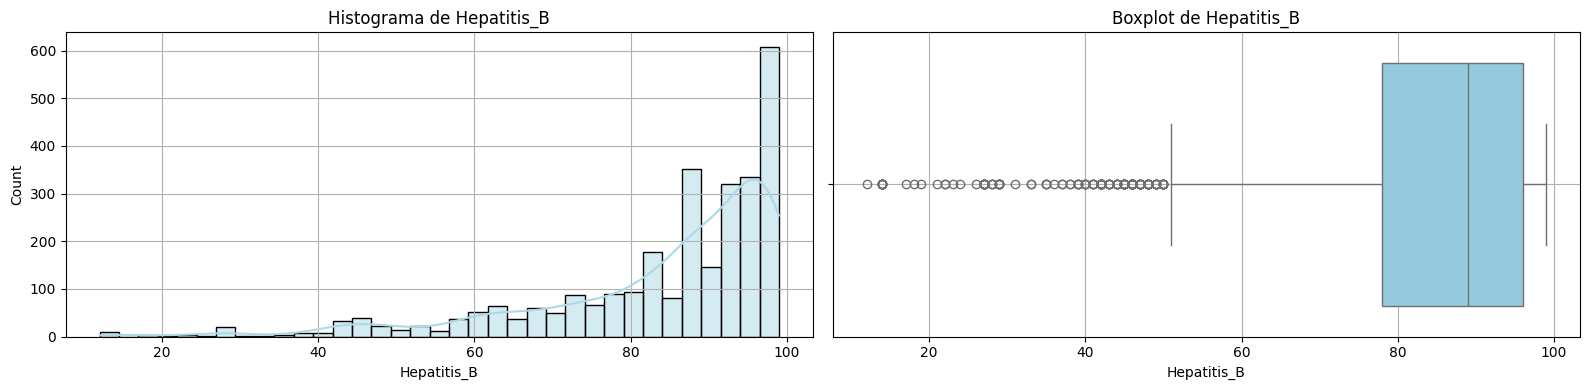

Moda: 99.00 | Mediana: 89.00 | Media: 84.29
Asimetría: -1.66 → Asimetría negativa fuerte (cola izquierda)

Cantidad de outliers: 164
Media de outliers: 38.98
Mediana de outliers: 42.00
Porcentaje de registros considerados outliers: 5.73%

 Análisis de la columna: Measles
--------------------------------------------------


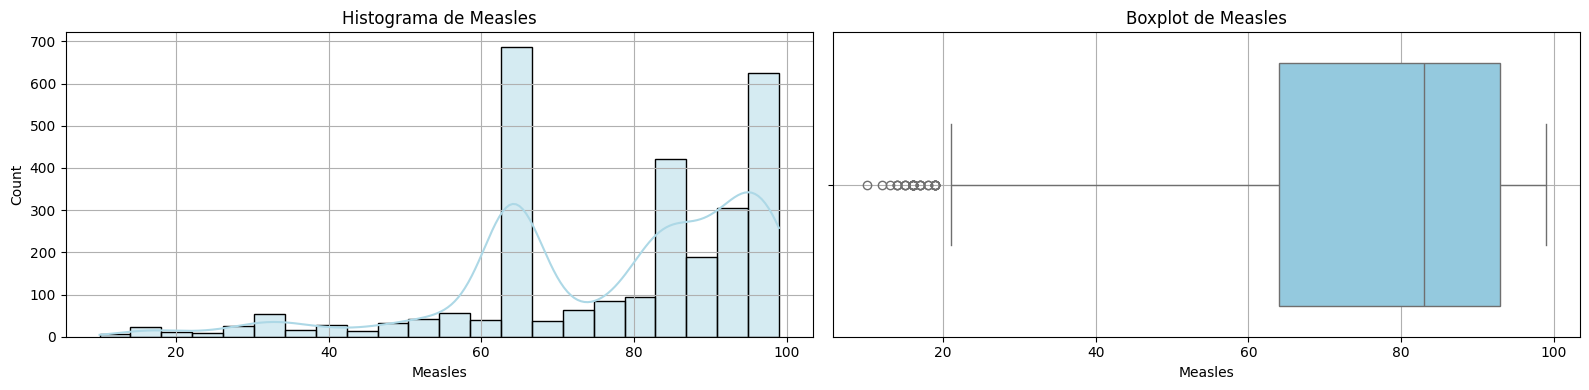

Moda: 64.00 | Mediana: 83.00 | Media: 77.34
Asimetría: -0.99 → Asimetría negativa moderada

Cantidad de outliers: 35
Media de outliers: 16.20
Mediana de outliers: 16.00
Porcentaje de registros considerados outliers: 1.22%

 Análisis de la columna: BMI
--------------------------------------------------


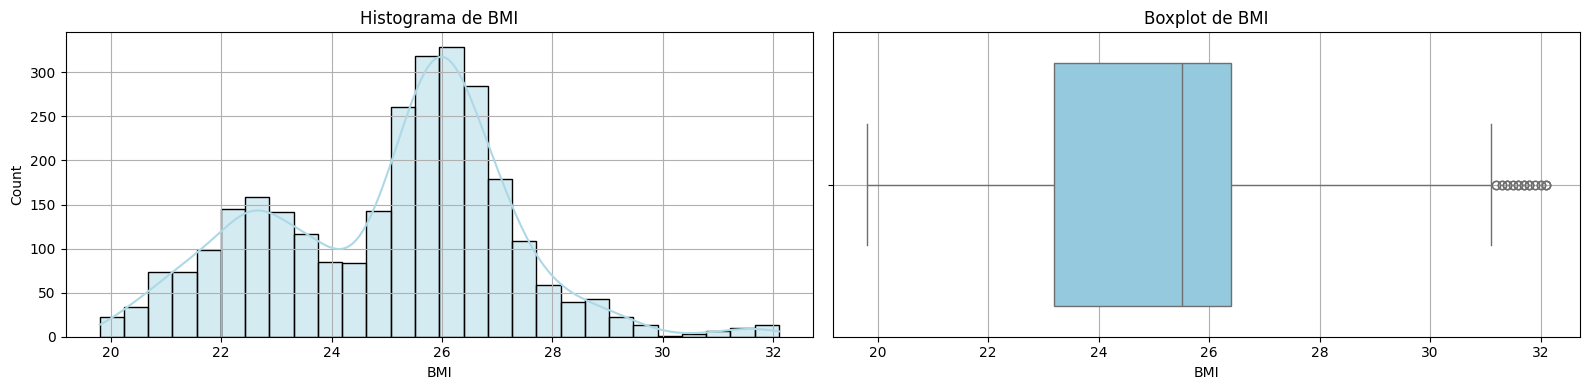

Moda: 26.00 | Mediana: 25.50 | Media: 25.03
Asimetría: -0.12 → Distribución aproximadamente simétrica

Cantidad de outliers: 25
Media de outliers: 31.66
Mediana de outliers: 31.70
Porcentaje de registros considerados outliers: 0.87%

 Análisis de la columna: Polio
--------------------------------------------------


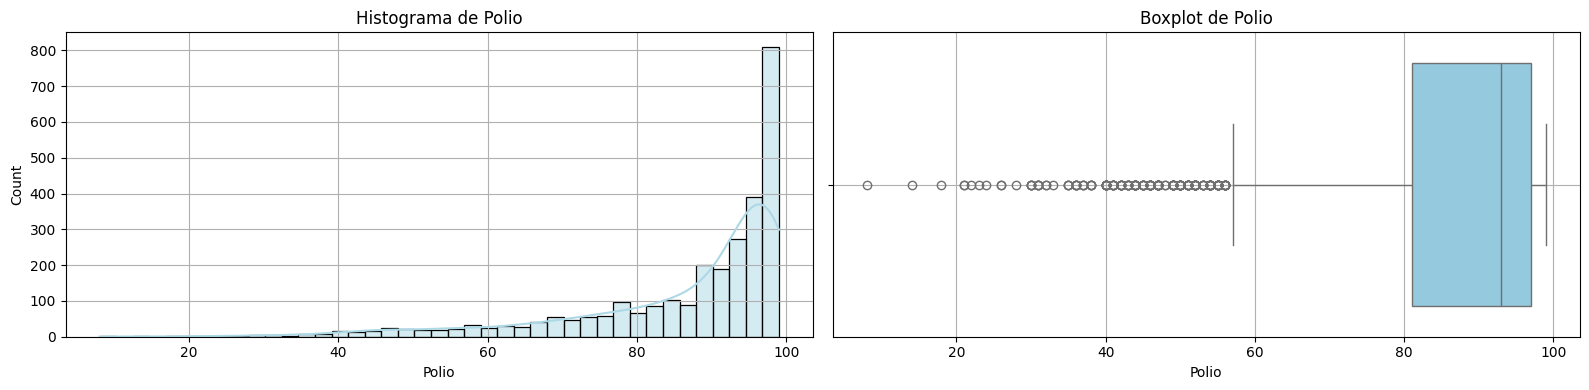

Moda: 99.00 | Mediana: 93.00 | Media: 86.50
Asimetría: -1.73 → Asimetría negativa fuerte (cola izquierda)

Cantidad de outliers: 190
Media de outliers: 44.96
Mediana de outliers: 47.00
Porcentaje de registros considerados outliers: 6.63%

 Análisis de la columna: Diphtheria
--------------------------------------------------


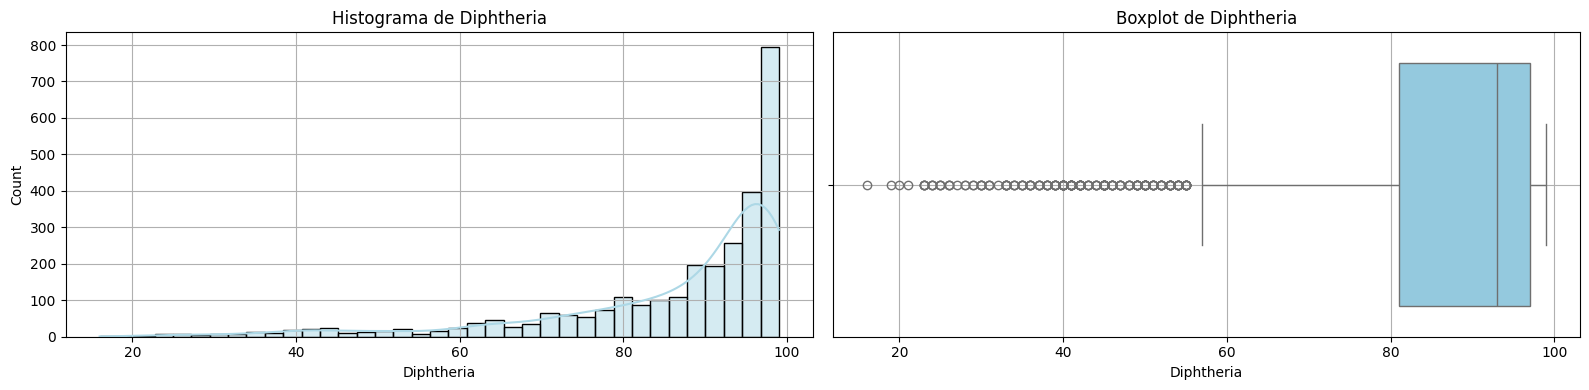

Moda: 99.00 | Mediana: 93.00 | Media: 86.27
Asimetría: -1.83 → Asimetría negativa fuerte (cola izquierda)

Cantidad de outliers: 187
Media de outliers: 41.71
Mediana de outliers: 42.00
Porcentaje de registros considerados outliers: 6.53%

 Análisis de la columna: Incidents_HIV
--------------------------------------------------


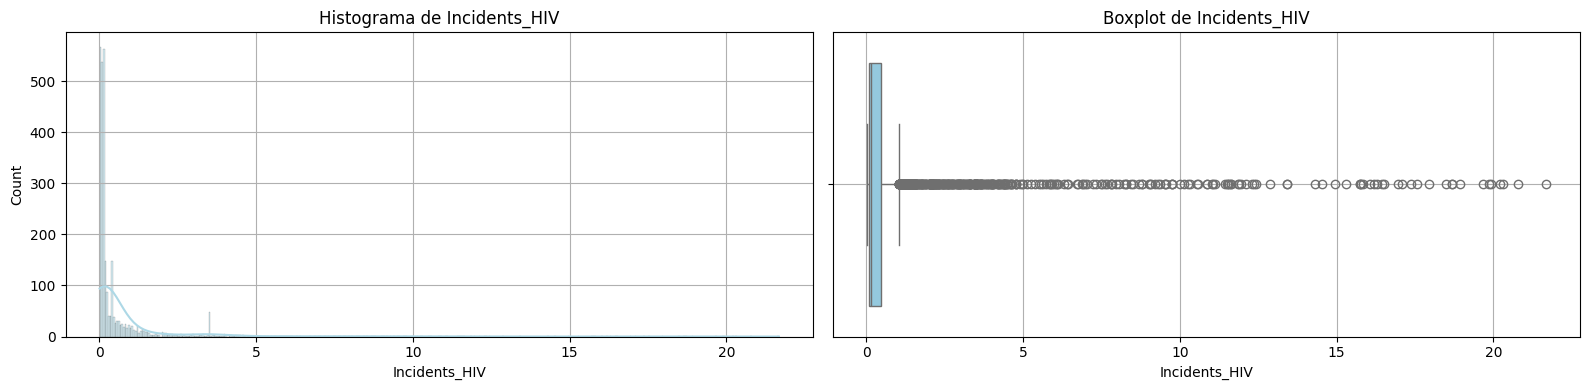

Moda: 0.08 | Mediana: 0.15 | Media: 0.89
Asimetría: 4.98 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 461
Media de outliers: 4.52
Mediana de outliers: 3.17
Porcentaje de registros considerados outliers: 16.10%

 Análisis de la columna: GDP_per_capita
--------------------------------------------------


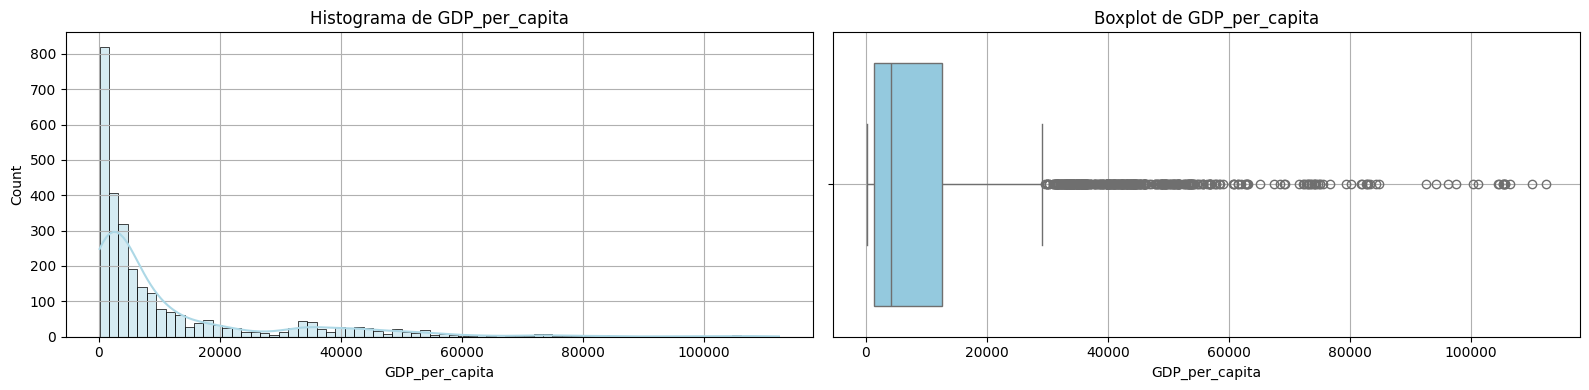

Moda: 554.00 | Mediana: 4217.00 | Media: 11540.92
Asimetría: 2.38 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 425
Media de outliers: 46994.17
Mediana de outliers: 42655.00
Porcentaje de registros considerados outliers: 14.84%

 Análisis de la columna: Thinness_ten_nineteen_years
--------------------------------------------------


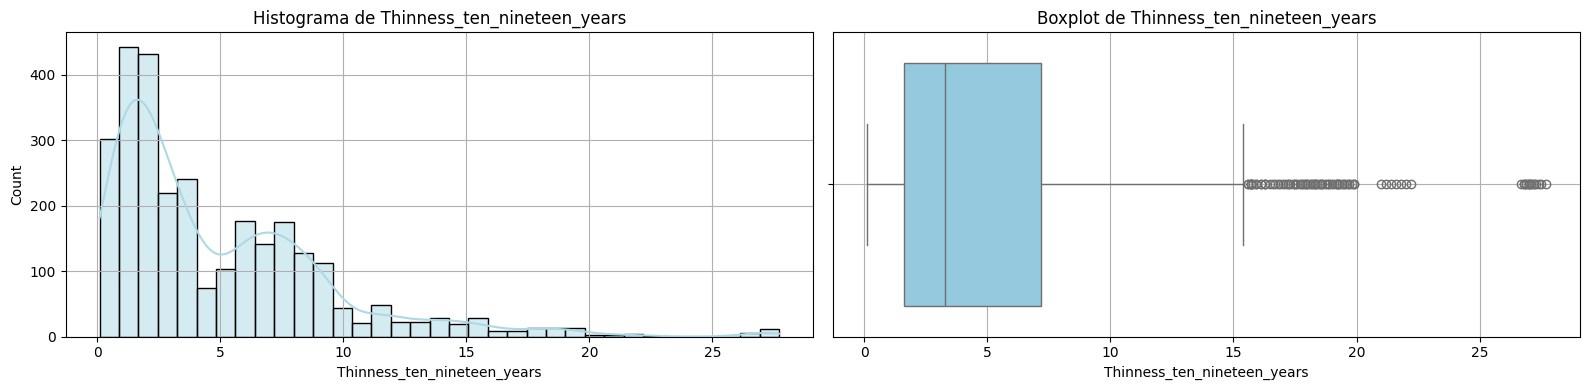

Moda: 1.00 | Mediana: 3.30 | Media: 4.87
Asimetría: 1.70 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 89
Media de outliers: 19.78
Mediana de outliers: 18.60
Porcentaje de registros considerados outliers: 3.11%

 Análisis de la columna: Thinness_five_nine_years
--------------------------------------------------


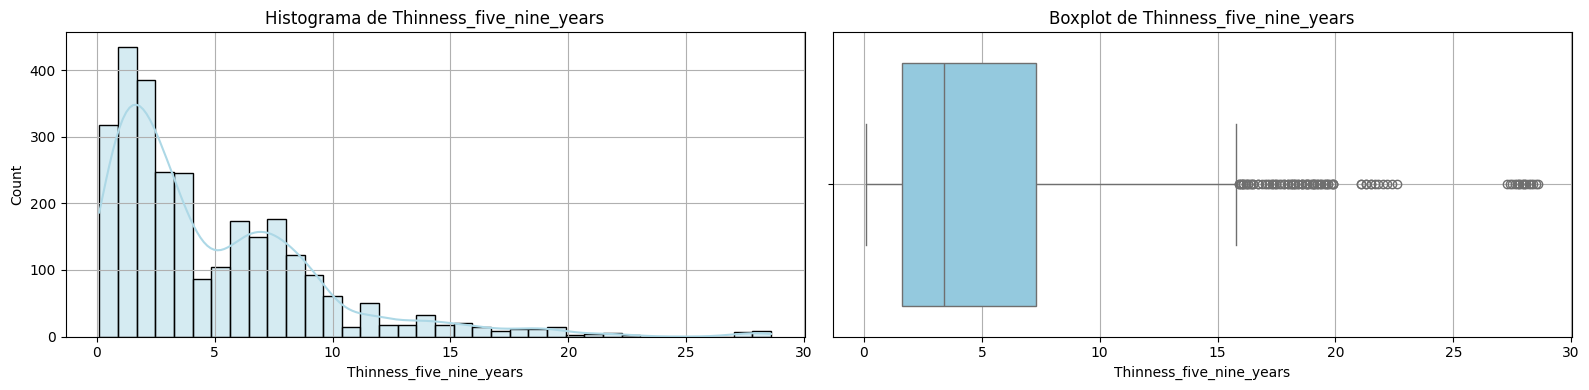

Moda: 0.90 | Mediana: 3.40 | Media: 4.90
Asimetría: 1.77 → Asimetría positiva fuerte (cola derecha)

Cantidad de outliers: 95
Media de outliers: 20.12
Mediana de outliers: 18.90
Porcentaje de registros considerados outliers: 3.32%

 Análisis de la columna: Schooling
--------------------------------------------------


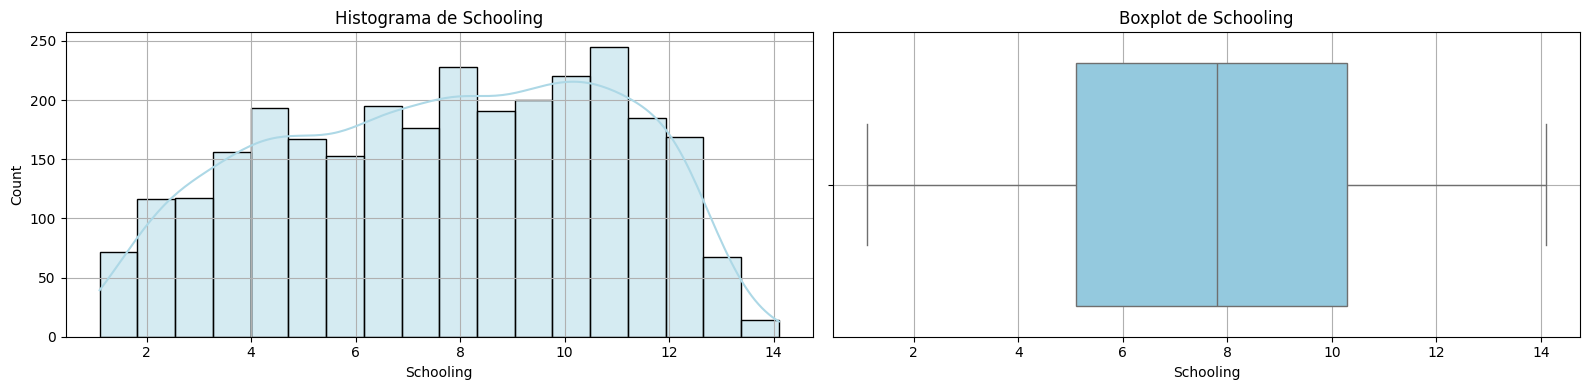

Moda: 8.40 | Mediana: 7.80 | Media: 7.63
Asimetría: -0.16 → Distribución aproximadamente simétrica

No se encontraron outliers con el criterio definido.

 Análisis de la columna: Life_expectancy
--------------------------------------------------


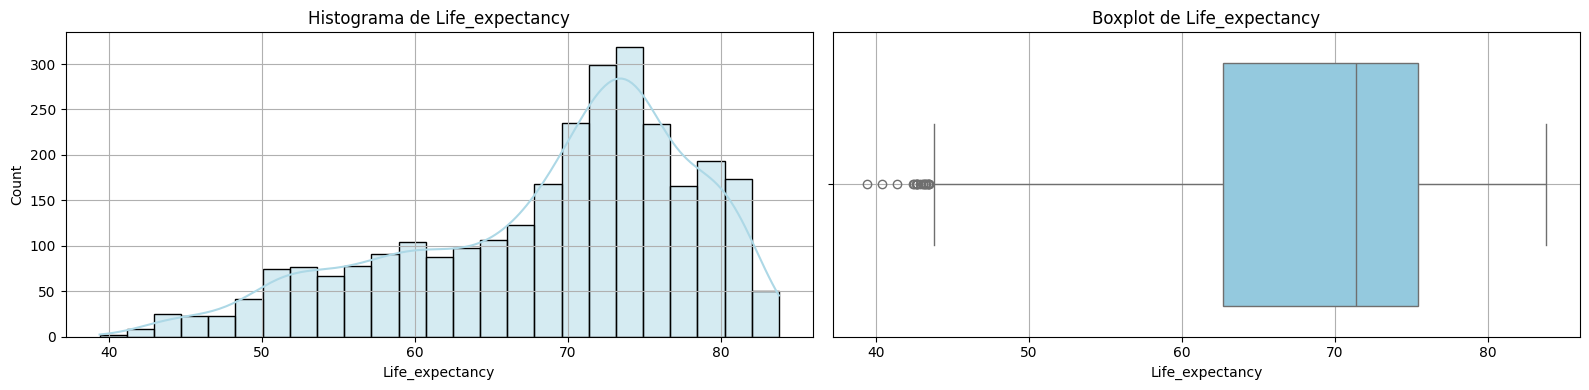

Moda: 72.60 | Mediana: 71.40 | Media: 68.86
Asimetría: -0.77 → Asimetría negativa moderada

Cantidad de outliers: 19
Media de outliers: 42.60
Mediana de outliers: 42.90
Porcentaje de registros considerados outliers: 0.66%


In [ ]:
columnas_a_analizar = [
    'Infant_deaths',
    'Under_five_deaths',
    'Adult_mortality',
    'Alcohol_consumption',
    'Hepatitis_B',
    'Measles',
    'BMI',
    'Polio',
    'Diphtheria',
    'Incidents_HIV',
    'GDP_per_capita',
    'Thinness_ten_nineteen_years',
    'Thinness_five_nine_years',
    'Schooling',
    'Life_expectancy']

dataset_con_outliers = marcar_outliers(dataset, columnas_a_analizar,1.5)

Observamos el dataset ajustado para verificar la estructura y distribución de las variables luego de la eliminación de columnas no relevantes, asegurándonos de que los datos estén listos para los análisis posteriores.

In [ ]:
dataset_con_outliers.head()

,Infant_deaths,Under_five_deaths,Adult_mortality,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,...,Outlier_Measles,Outlier_BMI,Outlier_Polio,Outlier_Diphtheria,Outlier_Incidents_HIV,Outlier_GDP_per_capita,Outlier_Thinness_ten_nineteen_years,Outlier_Thinness_five_nine_years,Outlier_Schooling,Outlier_Life_expectancy
0,11.1,13.0,105.8240,97,65,27.8,97,97,0.08,11006,...,0,0,0,0,0,0,0,0,0,0
1,2.7,3.3,57.9025,97,94,26.0,97,97,0.09,25742,...,0,0,0,0,0,0,0,0,0,0
2,51.5,67.9,201.0765,60,35,21.2,67,64,0.13,1076,...,0,0,0,0,0,0,1,1,0,0
3,32.8,40.5,222.1965,93,74,25.3,92,93,0.79,4146,...,0,0,0,0,0,0,0,0,0,0
4,3.4,4.3,57.9510,97,89,27.0,94,94,0.08,33995,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
dataset = dataset_con_outliers
dataset.head()

,Infant_deaths,Under_five_deaths,Adult_mortality,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,...,Outlier_Measles,Outlier_BMI,Outlier_Polio,Outlier_Diphtheria,Outlier_Incidents_HIV,Outlier_GDP_per_capita,Outlier_Thinness_ten_nineteen_years,Outlier_Thinness_five_nine_years,Outlier_Schooling,Outlier_Life_expectancy
0,11.1,13.0,105.8240,97,65,27.8,97,97,0.08,11006,...,0,0,0,0,0,0,0,0,0,0
1,2.7,3.3,57.9025,97,94,26.0,97,97,0.09,25742,...,0,0,0,0,0,0,0,0,0,0
2,51.5,67.9,201.0765,60,35,21.2,67,64,0.13,1076,...,0,0,0,0,0,0,1,1,0,0
3,32.8,40.5,222.1965,93,74,25.3,92,93,0.79,4146,...,0,0,0,0,0,0,0,0,0,0
4,3.4,4.3,57.9510,97,89,27.0,94,94,0.08,33995,...,0,0,0,0,0,1,0,0,0,0


#Entrenamiento del modelo usando regresión lineal

Seleccionamos las variables feature y target del dataset previamente procesado.

In [ ]:
features = [
    'Infant_deaths',
    'Under_five_deaths',
    'Adult_mortality',
    'Hepatitis_B',
    'Measles',
    'BMI',
    'Polio',
    'Diphtheria',
    'Incidents_HIV',
    'GDP_per_capita',
    'Thinness_ten_nineteen_years',
    'Thinness_five_nine_years',
    'Schooling',
    'Economy_status_Developed',
]
x = dataset[features]
y = dataset['Life_expectancy']

Dividimos el dataset en un 70% para el conjunto de entrenamiento y un 30% para el conjunto de pruebas.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=60
)

# Ahora X_train, X_test, y_train, y_test están listos para usarse
print("Tamaño de X_train:", x_train.shape)
print("Tamaño de X_test:", x_test.shape)



Tamaño de X_train: (2004, 14)
Tamaño de X_test: (860, 14)


Realizamos el entrenamiento del modelo con los parámetros seleccionados.

In [ ]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

Se eligió el MAE (Error Absoluto Medio) como métrica porque:

- Es fácil de interpretar, ya que indica el error promedio en años.
- Es robusto frente a los outliers presentes en nuestro modelo.
- Facilita la comparación entre modelos o ajustes de variables.

Y además, complementamos con el coeficiente de determinación R² para medir la calidad del ajuste del modelo a los datos.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error absoluto medio (MAE):", mae)
print("Coeficiente de determinación (R^2):", r2)

Error absoluto medio (MAE): 1.102639978250861
Coeficiente de determinación (R^2): 0.9769103296484168


Se realizó un ajuste en las variables features para intentar simplificar el modelo sin comprometer su rendimiento. Para ello, se aplicaron los siguientes criterios:
- Se eliminaron todas las variables cuya correlación con la variable target (esperanza de vida) fuera menor al 60%, estimando el menor impacto posible en el modelo.
- Se descartaron variables que estaban altamente correlacionadas entre sí, conservando solo una de cada grupo de variables redundantes.

In [ ]:
# Selección ajustada de variables feature
features_v2 = [
    'Infant_deaths',
    'Adult_mortality',
    'BMI',
    'Diphtheria',
    'Schooling',
]
x_v2 = dataset[features_v2]
y_v2 = dataset['Life_expectancy']

# División en conjunto de entrenamiento y de pruebas
x_train_v2, x_test_v2, y_train_v2, y_test_v2 = train_test_split(
    x_v2, y_v2, test_size=0.3, random_state=60
)

# Entrenamiento del modelo con ajustes
linreg_v2 = LinearRegression()
linreg_v2.fit(x_train_v2, y_train_v2)
y_pred_v2 = linreg_v2.predict(x_test_v2)
#print('Y Pred: \n', y_pred)

# Cálculo y visualización de métricas
mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)

print("Error absoluto medio (MAE):", mae_v2)
print("Coeficiente de determinación (R^2):", r2_v2)

Error absoluto medio (MAE): 1.217956587681546
Coeficiente de determinación (R^2): 0.9734977710800613


In [ ]:
# Comparación y explicación de los cambios en las métricas del modelo
print("\nComparación de métricas:")
print("------------------------------------")
print("Modelo Original:")
print(f"  Error absoluto medio (MAE): {mae:.4f}")
print(f"  Coeficiente de determinación (R^2): {r2:.4f}")
print("\nModelo Ajustado (v2):")
print(f"  Error absoluto medio (MAE): {mae_v2:.4f}")
print(f"  Coeficiente de determinación (R^2): {r2_v2:.4f}")
print("------------------------------------")



Comparación de métricas:
------------------------------------
Modelo Original:
  Error absoluto medio (MAE): 1.1026
  Coeficiente de determinación (R^2): 0.9769

Modelo Ajustado (v2):
  Error absoluto medio (MAE): 1.2180
  Coeficiente de determinación (R^2): 0.9735
------------------------------------


Análisis del cambio:
------------------------------------
El Error absoluto medio (MAE) ha aumentado ligeramente de 1.1026 a 1.2180, es decir que el modelo se equivoca en promedio un poco más de un mes adicional por predicción.
Esto indica que, en promedio, la diferencia entre las predicciones del modelo ajustado y los valores reales de la esperanza de vida es ligeramente mayor que en el modelo original.

El Coeficiente de determinación (R^2) ha disminuido levemente de 0.9769 a 0.9735, lo cual sugiere que el modelo ajustado explica una proporción ligeramente menor de la variabilidad total en la esperanza de vida en comparación con el modelo original.

Aunque se observa que las métricas han empeorado ligeramente, esta pérdida es aceptable para nosotras, ya que obtenemos un modelo más fácilmente interpretable, con menor riesgo de overfitting, a cambio de una pequeña pérdida de precisión.